## More complecated Agents:

In practice, building systems that reliably execute on tasks is incredibly challenging. While agents offer dynamic decision-making capabilities, their flexibility can sometimes result in unpredictable or suboptimal behavior, particularly in production environments. As we’ve worked with users to put agents into production, we’ve learned that achieving consistent and accurate outcomes often requires more control and structure. In practice though, it is incredibly difficult to build systems that reliably execute on these tasks.

For instance, you might need an agent to always call a specific tool first, ensure a predefined sequence of actions, or use tailored prompts depending on its state or context. This level of precision is difficult to achieve with unstructured agent workflows alone. To address these challenges, LangChain introduces LangGraph, a framework that allows developers to define workflows and decision paths in a more structured and deterministic way.

### LangGraph enables users to:

* Define Explicit Paths: Establish clear decision-making workflows, ensuring that agents follow specific sequences or conditions.
* State-Aware Execution: Adapt prompts and tool usage dynamically based on the agent's state, enabling more context-sensitive behavior.
* Blend Flexibility and Control: Combine the adaptability of agents with the reliability of structured logic, making it easier to meet production-grade requirements.

By incorporating LangGraph, developers can move beyond purely reactive agents to build systems that are both agentic and reliable, bridging the gap between flexibility and control. This approach ensures that agents not only make intelligent decisions but also adhere to the operational constraints and business logic necessary for robust performance in real-world applications.

LangGraph provides a structured framework for building workflows that leverage language models and tools in a highly controlled and deterministic manner. Below is an expanded overview of the core concepts mentioned on the [LangGraph High-Level Concepts page](https://langchain-ai.github.io/langgraph/concepts/high_level/), with additional context and examples.

### Key Concepts in LangGraph

LangGraph's low-level concepts focus on how workflows are represented, emphasizing the interplay between states, nodes, and edges.

### 1. `State`
The state represents the current status or context of the workflow at any given moment. Technically, the state is implemented as a TypedDict or a Pydantic model, which provides a structured and validated way to represent and manipulate data.

#### Key Features:

* Dynamic Updates: The state evolves as the workflow progresses, reflecting changes in real time.
* Context Awareness: Keeps track of past interactions or memory, ensuring seamless continuity.
* Flexible Prompts: Adjusts outputs dynamically based on the current state.
* Data Validation: Ensures safety and accuracy through strict typing and validation.


### 2. `Node`

Nodes represent discrete units of work or logic within the workflow. Technically, nodes are implemented as Python functions that encapsulate specific tasks. Each node interacts with the state and may invoke tools, APIs, or other resources.

#### Key Features:

* Defined Tasks: Nodes handle anything from simple actions to complex operations.
* Tool Integration: Nodes often call external resources like APIs or tools.
* State Interaction: They read and update the state to guide workflow progression.
* Reusable Design: Nodes are modular, making it easy to build workflows by combining small, reusable functions.


### 3. `Edge`

Edges define the transitions between nodes, dictating the flow of execution within the workflow. Technically, edges are implemented as conditional logic or callable objects that evaluate the current state and determine the next node to execute.

#### Key Features:

* Conditional Paths: Edges use rules to decide the next step (e.g., if-else logic).
* Sequential Control: Maintains a predictable order of operations.
* Adaptability: Adjusts dynamically to changing state conditions.
* Visualization: Helps map out and debug workflows more easily.


For more information you can check [LangGraph Low-Level Concepts page](https://langchain-ai.github.io/langgraph/concepts/low_level/)

Let's dive in greating simple graph! this example is coming from `langchain-academy`.

Let’s start with the simplest form of graph in LangGraph:

## State
The following state definition uses a `TypedDict` to store one piece of information, called `graph_state`, which is just a string. Even though it’s simple, this type of state can be very helpful for many tasks, such as:

* Tracking Progress: Keeping track of where you are in a workflow or process.

* Storing Context: Remembering the current step or stage in a conversation or task.

* Keeping Notes: Holding small pieces of important information, like the active node in a process.

(more info [here](https://medium.com/@gitmaxd/understanding-state-in-langgraph-a-comprehensive-guide-191462220997))

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## Nodes
As defined in langchain-academy, [Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions.
The first positional argument is the state, as defined above.
Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.
Each node returns a new value of the state key `graph_state`.
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [17]:
def node_greeting(state):
    print("---Node Greeting---")
    return {"graph_state": state['graph_state'] + " Hello! I am"}

def node_happy(state):
    print("---Node Happy---")
    return {"graph_state": state['graph_state'] + " very happy today!"}

def node_sad(state):
    print("---Node Sad---")
    return {"graph_state": state['graph_state'] + " very sad!"}


## Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_greeting` to `node_question`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges) are used want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [18]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_happy", "node_sad"]:
    print("---Deciding Next Node---")
    
    user_input = state['graph_state']
    
    # Here, let's just do a 50 / 50 split between nodes
    if random.random() < 0.5:

        # 50% of the time, we return Node happy
        return "node_happy"
    
    # 50% of the time, we return Node sad
    return "node_sad"

## Graph Construction
In this step, we create a graph using the StateGraph class, which is the foundational class for building workflows in LangGraph.

**Steps**:

1. Initialize the StateGraph

    * Begin by initializing a StateGraph using the `State` class we defined earlier. This establishes the structure to hold the graph’s workflow logic.
2. Add `Nodes` and `Edges`

    * Add the functional components (nodes) that represent tasks or decisions in the workflow.
    * Define the connections (edges) between these nodes to control the flow of execution.
3. Set Starting Point

    * Use the START node as the entry point for the graph. This special node handles user input and directs it to the appropriate starting node.
4. Define the Endpoint

    * Incorporate the END node to signal the conclusion of the graph's workflow.
5. Compile the Graph

    * Perform a validation step by compiling the graph. This ensures that the structure is consistent and ready for execution.
6. Visualize the Graph

    * Generate a Mermaid diagram to visually represent the nodes and edges, making it easier to understand and debug the workflow.

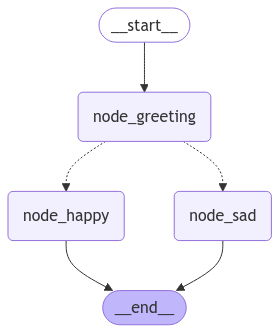

In [19]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_greeting", node_greeting)
builder.add_node("node_happy", node_happy)
builder.add_node("node_sad", node_sad)

# Logic
builder.add_edge(START, "node_greeting")
builder.add_conditional_edges("node_greeting", decide_mood)
builder.add_edge("node_happy", END)
builder.add_edge("node_sad", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invocation

Once the graph is compiled, you can execute it using the `invoke` method. This method is part of LangChain's [Runnable Protocol](https://python.langchain.com/v0.1/docs/expression_language/interface/), which standardizes the execution process for LangChain components.

### Key Steps in Graph Invocation

1. **Initializing the Input State**
   - Before execution, the graph requires an initial input state to begin processing.
   - Example:
     ```python
     {"graph_state": "Hi, this is Shakiba."}
     ```
     This dictionary initializes the `graph_state` and provides the starting context for the workflow.

2. **Execution Flow**
   - The graph begins execution from the `START` node, which is the entry point.
   - It then progresses through the nodes (`node_greeting`, `node_happy`, `node_sad`), following the structure and rules defined during graph construction.
   - Conditional edges are evaluated during execution to decide the next node. For example, a 50/50 random decision might lead the graph to either `node_happy` or `node_sad`.

3. **State Updates**
   - At each step:
     - The current state is passed as input to the node function.
     - The node processes the input and returns an updated state.
     - The new state is then used for the subsequent nodes.

4. **Reaching the End**
   - The workflow continues until it arrives at the `END` node, signaling the completion of the graph execution.

### Why Use `invoke`?
The `invoke` method simplifies the process of running the graph by handling:
- Node execution
- Edge traversal
- State management

This ensures a seamless execution flow without requiring manual intervention, allowing you to focus on building robust workflows.

For further details, refer to the [LangGraph Low-Level Concepts](https://langchain-ai.github.io/langgraph/concepts/low_level/).


In [22]:
graph.invoke({"graph_state" : "Hi, this is Shakiba."})

---Node Greeting---
---Deciding Next Node---
---Node Happy---


{'graph_state': 'Hi, this is Shakiba. Hello! I am very happy today!'}